<a href="https://colab.research.google.com/github/CrAvila/IA/blob/main/Taller2/IA_Taller_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div>
<img src="https://drive.google.com/uc?export=download&id=1lhTXu7FShFdtXWptJH3ZOPyxOdFY8kOf" width="500"/>
</div>


## Pontificia Universidad Javeriana

#### Departamento de Ingeniería Electrónica

#### Inteligencia Artificial

## Taller 2: Descenso Gradiente

Alumno: Carlos Roberto Ávila Hernández

Profesor: Alexander Caicedo Dorado

El Descenso Gradiente es una técnica de optimización muy utilizada para la regresión lineal en el aprendizaje automático por varias razones. En primer lugar, ofrece escalabilidad y eficiencia de memoria, lo que la hace adecuada para grandes conjuntos de datos en los que las operaciones matriciales de la solución de forma cerrada pueden resultar costosas desde el punto de vista computacional. También es adaptable al aprendizaje en línea, lo que permite que los modelos se actualicen continuamente a medida que llegan nuevos datos. A continuación se desarrollará una implementación interactiva en Python para modelos lineales y multilineales.

Comenzaremos por la exploración de datos en una variable:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import random
import seaborn as sns

%matplotlib inline

In [2]:
# Cargando el archivo de Excel con los datos
data = pd.read_excel('https://drive.google.com/uc?export=download&id=1vbXDOM9LSiewrA1BGuGT1NQb5V6q66Z5')
print(data.shape)

(414, 8)


In [3]:
# Observando datos
display(data)

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.666667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250000,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000000,8.1,104.81010,5,24.96674,121.54067,52.5


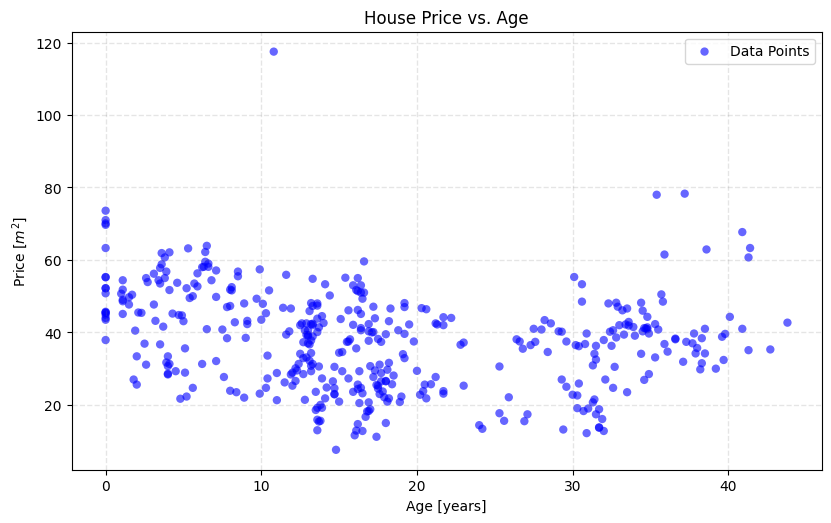

In [4]:
# Data
x = data['X2 house age']
y = data['Y house price of unit area']

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Scatter plot with labeled data
plt.scatter(x, y, alpha=0.6, edgecolors='none', color='blue', label='Data Points')

# Adjusting spacing
plt.subplots_adjust(top=0.88, bottom=0.15, left=0.15, right=0.9)

# Adding grid lines with subtle visibility
plt.grid(True, alpha=0.2, linewidth=1.0, linestyle='--', color='gray')

# Adding legend with a frame
legend = plt.legend(frameon=True)
legend.get_frame().set_alpha(0.8)  # Adjust the legend box opacity

# Simplified labels and title
plt.xlabel('Age [years]')
plt.ylabel('Price [$m^2$]')
plt.title('House Price vs. Age')

# Display the plot
plt.show()


Lo que nos interesa es ser capaces de estimar los valores de salida (Y: Precios de la Casa) en función de alguna/s de las variables disponibles. Para ello, recordaremos las fórmulas del Descenso Gradiente para este tipo de problemas siguiendo la nomenclatura:

1. m es el número de observaciones (ejemplos de entrenamiento)
2. n es el número de caracterisicas (regresores)
3. $x_j^{(i)}$ es el valor de la caracteristica (regresor) $j$ en la $i$-ésima observación.
4. $\mathbf{x}^{(i)}$ es el vector de caracteristicas (regresores) de la $i-$ésima observación, y $\mathbf{x} \in \mathbb{R}^n$.
5. $\boldsymbol{\theta}$ es un vector columna con $n+1$, $\boldsymbol{\theta} \in \mathbb{R}^{n+1}$. (El $+1$ proviene del vector de unos que acompaña a $\theta_0$).

Ahora nuestro modelo contiene $n$ regresores y es de la forma:

$$h_\theta(x)= \theta_0+\theta_1x_1+\ldots+\theta_nx_n.$$

Lo cual se puede representar de forma vectorial como:

$$\mathbf{h_\theta(x)}= \boldsymbol{\theta}^{\text{T}}\mathbf{x}.$$

$$ \begin{equation}
   \begin{split}
      \theta_0 &= \frac{1}{m}\sum_{i=1}^{m}\left[h_\theta(x^{(i)})-y^{(i)}\right]x_0^{(i)}\\
      \theta_1 &= \frac{1}{m}\sum_{i=1}^{m}\left[h_\theta(x^{(i)})-y^{(i)}\right]x_1^{(i)}\\
      &  \vdots\\
      \theta_n &= \frac{1}{m}\sum_{i=1}^{m}\left[h_\theta(x^{(i)})-y^{(i)}\right]x_n^{(i)}\\
   \end{split}
   \end{equation}$$
   
Donde $x_0^{(i)}= 1$ para todo $i$.

Para implementarlo utilizaremos las siguientes funciones:

Una que reciba de entrada los parámetros $\boldsymbol\theta$ y la matriz de entrada $\mathbf{A}$, y calcule como salida $\mathbf{h}_{\boldsymbol\theta}$

In [5]:
def h_theta(theta, A):
    return A@theta

Una  que reciba como entrada los parámetros $\boldsymbol\theta$, la salida del modelo $\mathbf{h}_{\boldsymbol\theta}$ y la salida esperada $\mathbf{y}$, y produzca como salida el valor de la función de costo $J$.

In [6]:
def J(theta, h_theta, y):
    m = len(y)
    e = h_theta - y
    J = 1/m * e.T@e
    return J

Una que calcule la derivada de la funcióm de costo, recibe como entrada los parámetros $\boldsymbol\theta$, la salida del modelo $\mathbf{h}_{\boldsymbol\theta}$ y la salida esperada $\mathbf{y}$, y produce como salida el gradiente $\nabla_{\boldsymbol\theta}J=\left[\frac{\partial J}{\partial_{\theta_0}} \quad \frac{\partial J}{\partial_{\theta_0}} \quad \ldots \quad \frac{\partial J}{\partial_{\theta_n}}\right]^{\text{T}}$.

In [7]:
def gradient(A, theta, h_theta, y):
    dj = 1/(len(y)) * A.T@(h_theta - y)
    return dj

Una que realiza la actualización de los datos, recibe como entraba $\boldsymbol\theta[j]$, la tasa de aprendizaje $\eta$, la matriz de entrada $\mathbf{A}$ la salida del modelo $\mathbf{h}_{\boldsymbol\theta}$ y la salida esperada $\mathbf{y}$, y produzca como salida los parámetros actualizados $\boldsymbol\theta[j+1]$.

In [8]:
def update_theta(theta, eta, A, h_theta, y):
    theta = theta - eta * gradient(A, theta, h_theta, y)
    return theta

En el proceso de aplicación de la regresión lineal de múltiples variables surgieron dificultades debido a las importantes variaciones en las escalas de variables específicas, en particular las que representan años o variables numéricamente grandes. Estas disparidades dieron lugar a una función de error notablemente elevada, lo que supuso un obstáculo para la aplicación satisfactoria del descenso de gradiente sin normalización. Para resolver este problema y mantener la coherencia en el proceso de optimización, se determinó que era necesario normalizar los datos de todas las variables.

La normalización desempeña un papel fundamental en la optimización por descenso de gradiente al normalizar las escalas de cada variable. En los casos en que las variables presentan diferencias de escala considerables, el proceso de optimización puede encontrar dificultades de convergencia e ineficiencias. Al normalizar uniformemente todas las variables, la contribución de cada característica a la función de coste se hace coherente y equilibrada. En consecuencia, el descenso de gradiente puede converger eficazmente y generar modelos de regresión precisos. Este procedimiento de normalización es fundamental para estabilizar y mejorar la eficacia general del flujo de trabajo de aprendizaje automático. Para este problema, se utilizó la normalización Mín-Máx.

La normalización Mín-Máx, también conocida como escalado de características, es una técnica de preprocesamiento de datos utilizada para transformar datos numéricos en un rango específico, normalmente [0, 1]. Se consigue mediante la siguiente fórmula:

$$x' = \frac{x - \text{min}_i}{\text{max}_i - \text{min}_i}$$

Donde:
- $x'$ es el valor normalizado de $x$.
- $x$ es el dato original.
- $\text{min}_i$ es el valor mínimo de la característica $i$.
- $\text{max}_i$ es el valor máximo de la característica $i$.

La fórmula resta el valor mínimo $\text{min}_i$ del valor original $x$ para llevarlo a una escala relativa a partir de 0. A continuación, se divide por el rango de valores $\text{max}_i - \text{min}_i$ para escalarlo entre $0$ y $1$.

Esta técnica de normalización es útil para garantizar que las diferentes características con diferentes escalas tienen un impacto coherente en los algoritmos de aprendizaje automático.



In [9]:
def normalize_data(col):
  # Normalize the data
  min_val = min(col)
  max_val = max(col)
  normalized_data = (col - min_val) / (max_val - min_val)
  return normalized_data, min_val, max_val

El problema es que ahora el modelo está entrenado con datos normalizados y para utilizarlo, tendríamos que normalizar cada dato de entrada. Al hacerlo y expandir este resultado, obtendríamos lo siguiente:

$$ \hat{y} = \theta_0' + \sum_{i=i}^n \theta_i' x_i'$$

Y tendríamos que normalizar cada entrada:

$$ \hat{y} = \theta_0' + \sum_{i=i}^n \theta_i' \left(\cfrac{x_i - min_i}{max_i - min_i}\right)$$

Al expandir esto, podemos deducir las siguientes fórmulas para ajustar los parámetros a las proporciones originales:

**1. Ajuste del Intercepto $ \theta_0' $:**

$$ \theta_0' = \theta_0 - \sum_{i=1}^n \theta_i \cdot \left(\frac{{\text{min}}_i}{{\text{max}}_i - {\text{min}}_i}\right) $$

**2. Ajuste de los Coeficientes $ \theta_i' $:**

$$\theta_i' = \theta_i \cdot \frac{1}{{\text{max}}_i - {\text{min}}_i} $$

Donde $ \theta_0' $ y $ \theta_i' $ son los interceptos y coeficientes ajustados, respectivamente, para datos no normalizados. $ \theta_0 $ y $ \theta_i $ son los valores originales obtenidos del entrenamiento con datos normalizados. $ {\text{min}}_i $ y $ {\text{max}}_i $ son los valores mínimo y máximo de los datos originales no normalizados para la característica $ i $, mientras que $ {\text{min}}_y $ y $ {\text{max}}_y $ son los valores mínimo y máximo de la variable de salida original no normalizada.


In [10]:
def denormalize_parameters(normalized_data, theta):
    rescaled_theta = []
    denormalized_intercept = theta[0]
    for i in range(1, len(theta)):
      #Denormalizing the parameter theta_0
        current_variable = list(normalized_data.keys())[i-1]
        min_i = normalized_data[current_variable]['min_value']
        max_i = normalized_data[current_variable]['max_value']
        denormalized_intercept -= theta[i] * (min_i / (max_i - min_i))

    rescaled_theta.append(denormalized_intercept)

    # Denormalizing the rest of parameters
    for variable, parameters, model_param in zip(normalized_data.keys(), normalized_data.values(), theta[1:]):
        min_value = parameters['min_value']
        max_value = parameters['max_value']

        # Adjust the model_param using the normalization formula
        rescaled_param = model_param / (parameters['max_value'] - parameters['min_value'])
        rescaled_theta.append(rescaled_param)


    return rescaled_theta

Algunas funciones auxiliares:

In [11]:
def get_columns(data, vars_to_use):
  # Get the columns from the dataframe of the vraiables selected
    selected_columns = [col for col in data.columns.tolist() if any(var in col for var in vars_to_use)]
    return selected_columns

In [12]:
def print_parameters(params):
  # Print the parameters
  print()
  for i in range(len(params)):
    print(f"Theta[{i}]: {params[i]}")
  print()
  return

In [13]:
def print_variables(selected_vars):
  #Print the selected vriables
    print()
    print()
    print(f"Selected Variables: ")
    print('')
    for var in selected_vars:
      print(var)
    print()

In [14]:
def print_info(label, value):
  # Print the information given with a label
  print()
  print(f"{label} : {value}")
  print()

In [15]:
def get_normalized_data(data, x_variables):
  # Iterate over the variables to normalize them
  dict = {
        variable : {
            'normalized' : normalize_data(data[variable])[0],
            'min_value' : normalize_data(data[variable])[1],
            'max_value' : normalize_data(data[variable])[2]
        } for variable in x_variables
    }
  return dict

In [16]:
def plot_cost(costs):
  # Create a new figure with customized settings
  plt.figure(figsize=(10, 6))
  sns.set(style='darkgrid')
  plt.title('Cost Function', fontsize=16)
  plt.xlabel('Epoch', fontsize=14)
  plt.ylabel('Cost', fontsize=14)

  # Plot the costs with a line plot
  plt.plot(costs, linestyle='-', markersize=5, color='b', label='Cost')

  # Add grid lines for better readability
  plt.grid(True, linestyle='--', alpha=0.7)

  # Add legend to the plot
  plt.legend(fontsize=12)

  # Customize the tick labels and sizes
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  # Add a horizontal line at y=0 for reference (optional)
  plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)

  # Save the plot as an image (optional)
  plt.savefig('cost_plot.png', dpi=300, bbox_inches='tight')

  # Show the plot
  plt.show()

In [17]:
def show_model(theta, variable_names):
    # Create the equation string
    intercept = theta[0]
    coefficients = theta[1:]
    equation = f'y = {intercept:.2f}'


    for i, variable in enumerate(variable_names):
        equation += f' + {coefficients[i]:.2f} * {variable}'

    return equation

In [21]:
def gradient_descent(selected_variables, eta, max_iterations):

  # Get variables from dataframe and normalize them
    x_variables = get_columns(data, selected_variables)
    max_iterations = int(max_iterations)
    normalized_data = get_normalized_data(data, x_variables)

    # Create matrices
    X = np.column_stack([normalized_data[var]['normalized'] for var in normalized_data])
    y = data['Y house price of unit area']

    # Get integers
    n = len(x_variables)
    m = len(y)

    # Initialize parameters
    A = np.column_stack([np.ones(m).T, X])
    theta = [random() for _ in range(n+1)]

    # Claculate initial values to start iterating
    h = h_theta(theta, A)
    e = h - y

    count = 0
    cost = 0
    previous_cost = 0
    costs = []

    for i in range(max_iterations):
      # Iterate
        previous_cost = J(theta, h, y)
        theta = update_theta(theta, eta, A, h, y)
        h = h_theta(theta, A)
        e = h-y
        cost = J(theta, h, y)

        if np.isinf(cost) or np.isnan(cost):
          break

        costs.append(cost)
        cost_diff = abs(previous_cost - cost)
        count += 1
        if cost_diff < 10**-15:
            break

    # Show Results
    theta = denormalize_parameters(normalized_data, theta)
    print_info("Learning Rate", eta)
    print_info("Max. Iterations: ", max_iterations)
    print(f"Parámetros:")
    print_parameters(theta)
    print(f"Número de Iteraciones: {count}")
    print(f"Costo Final: {cost}")

    print()
    print("Model:")
    print(show_model(theta, x_variables))
    print()
    print()
    plot_cost(costs)


    return


Ahora que podemos crear nuestros modelos, crearemos la pantalla de visualización junto con los widgets interactivos. En ellos se podrá especificar cuales variables usar, la tasa de aprendizaje y las iteraciones máximas para variar la exactitud.

In [22]:
import ipywidgets as widgets
from IPython.display import display

def show_program():

  print("Select the variables for the Regression Model:")
  available_variables = ['X1 transaction date',
                        'X2 house age',
                        'X3 distance to the nearest MRT station',
                        'X4 number of convenience stores',
                        'X5 latitude', 'X6 longitude']

  # Create a checkbox widget for each variable with adjusted width
  checkboxes = [widgets.Checkbox(description=var, layout=widgets.Layout(width='1000px')) for var in available_variables]

  # Create labels for the sliders
  label1 = widgets.Label(value='Learning Rate')
  label2 = widgets.Label(value='Max. Iterations')

  # Create two sliders with default values
  learning_rate_slider = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.01)
  iterations_slider = widgets.FloatSlider(value=0.0, min=0.0, max=50000, step=1)

  # Combine labels and sliders into horizontal boxes
  slider_box1 = widgets.HBox([label1, learning_rate_slider])
  slider_box2 = widgets.HBox([label2, iterations_slider])

  # Create a button to trigger the action
  button = widgets.Button(description="Get Regression", layout=widgets.Layout(width='500px'))

  # Function to handle button click event
  def get_selected_variables(button):
      selected_vars = [checkbox.description for checkbox in checkboxes if checkbox.value]
      if not selected_vars:
          print("Please select at least one variable.")
      else:
          learning_rate = learning_rate_slider.value
          max_iterations = int(iterations_slider.value)  # Convert to an integer
          print_variables(selected_vars)
          gradient_descent(selected_vars, learning_rate, max_iterations)

  # Assign the click event handler to the button
  button.on_click(get_selected_variables)

  # Display the widgets
  display(widgets.VBox(checkboxes + [slider_box1, slider_box2, button]))


Select the variables for the Regression Model:




Selected Variables: 

X1 transaction date
X2 house age
X3 distance to the nearest MRT station
X4 number of convenience stores
X5 latitude
X6 longitude


Learning Rate : 0.71


Max. Iterations:  : 50000

Parámetros:

Theta[0]: -14442.020782673711
Theta[1]: 5.1490169671175625
Theta[2]: -0.2696967263638457
Theta[3]: -0.0044875037503156546
Theta[4]: 1.1333252665343385
Theta[5]: 225.4702797190612
Theta[6]: -12.428772036470065

Número de Iteraciones: 5505
Costo Final: 77.12902119720445

Model:
y = -14442.02 + 5.15 * X1 transaction date + -0.27 * X2 house age + -0.00 * X3 distance to the nearest MRT station + 1.13 * X4 number of convenience stores + 225.47 * X5 latitude + -12.43 * X6 longitude




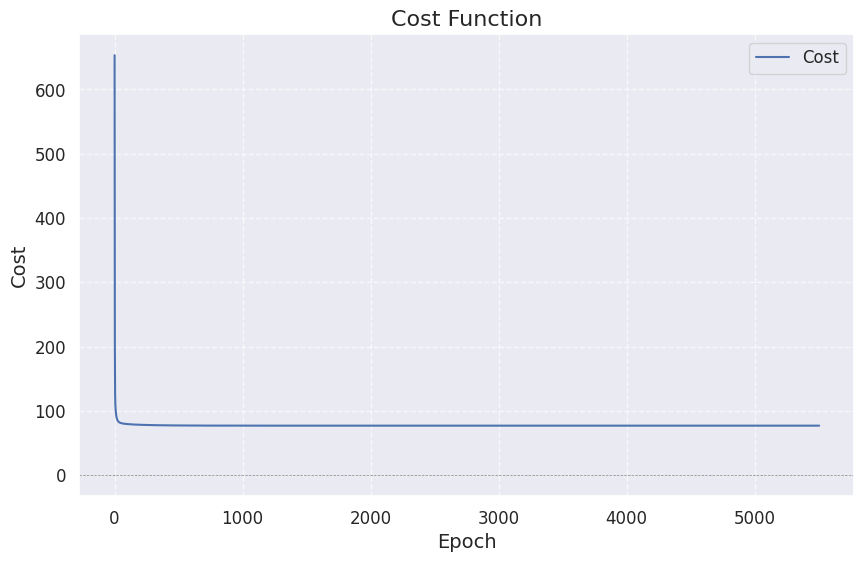

In [23]:
try:
  show_program()
except:
  print("Something went wrong. Probably the inputs or the algorithm diverged. ")